In [973]:
import os
from IPython.display import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Image
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

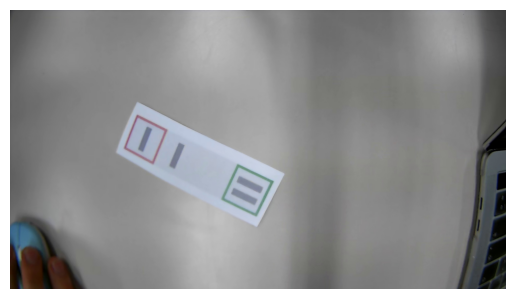

In [974]:
# Load the image
image = cv2.imread("1103_G1_14.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()

In [975]:
# Blur the image
image_blurred = cv2.GaussianBlur(image, (7,7), 0)

In [976]:
# Convert the image to grayscale and hsv
gray_image = cv2.cvtColor(image_blurred, cv2.COLOR_RGB2GRAY)
hsv_image = cv2.cvtColor(image_blurred, cv2.COLOR_RGB2HSV)

In [977]:
# Apply the hsv mask to the image. 
def apply_red_mask(hsv_image):
    # H = 120, S = 20, V = 0, H1 = 179, S1 = 255, V1 = 255
    lower_red = np.array([120, 20, 0])
    upper_red = np.array([179, 255, 255])
    mask_red = cv2.inRange(hsv_image, lower_red, upper_red)
    return mask_red

def apply_green_mask(hsv_image):
    # H = 50, S = 40, V = 0, H1 = 110, S1 = 255, V1 = 160
    lower_green = np.array([50, 40, 0])
    upper_green = np.array([110, 255, 160])
    mask_green = cv2.inRange(hsv_image, lower_green, upper_green)
    return mask_green

mask_red = apply_red_mask(hsv_image)
mask_green = apply_green_mask(hsv_image)

In [978]:
def close_erode_mask(mask):
    # Apply close the mask
    kernel = np.ones((7,7), np.uint16)   
    mask_closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Erode the mask
    kernel = np.ones((5,5), np.uint16)
    mask_eroded = cv2.dilate(mask_closed, kernel, iterations=1)
    
    return mask_eroded

mask_red = close_erode_mask(mask_red)
mask_green = close_erode_mask(mask_green)

In [979]:
def apply_mask_to_image(image, mask):
    segmented_image = cv2.bitwise_and(image, image, mask=mask)
    return segmented_image

segmented_red = apply_mask_to_image(gray_image, mask_red)
segmented_green = apply_mask_to_image(gray_image, mask_green)

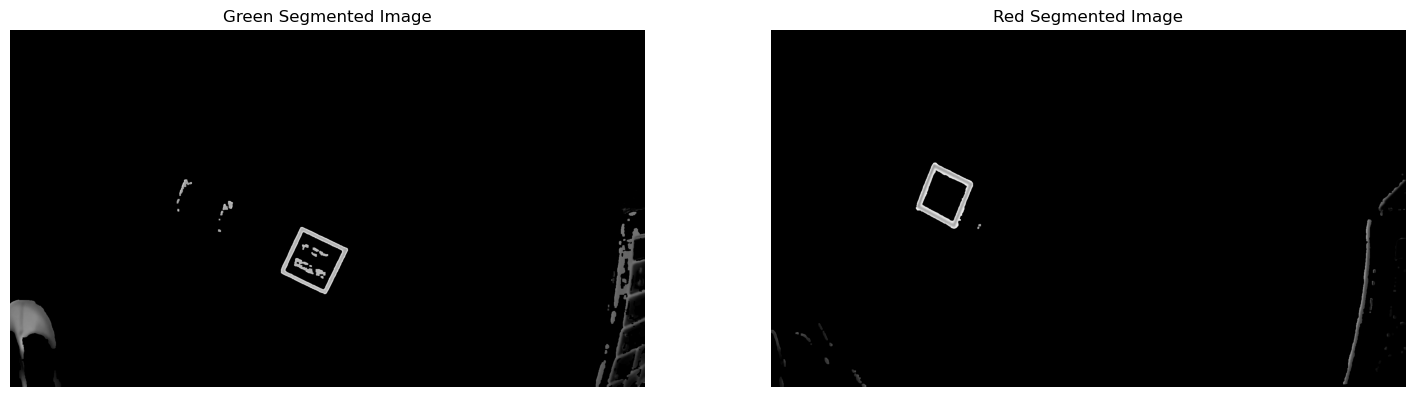

In [980]:
# Display the segmented images
plt.figure(figsize=[18, 5])
plt.subplot(1, 2, 1) ; plt.imshow(segmented_green, cmap='gray') ; plt.title('Green Segmented Image') ; plt.axis('off')
plt.subplot(1, 2, 2) ; plt.imshow(segmented_red, cmap='gray') ; plt.title('Red Segmented Image') ; plt.axis('off')
plt.show()

In [981]:
def sobel_filter_image(image, kernel_size):
    img_sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=kernel_size)
    img_sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=kernel_size) 
    img_sobel = np.sqrt(img_sobel_x**2 + img_sobel_y**2)
    img_sobel = cv2.normalize(img_sobel, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    # Adaptive threshold the image.
    ret, filtered_image = cv2.threshold(img_sobel, 40, 255, cv2.THRESH_BINARY)
    return filtered_image

filtered_green = sobel_filter_image(segmented_green, 11)
filtered_red = sobel_filter_image(segmented_red, 11)

In [982]:
def find_contours(filtered_image):
    # Find countours in the images
    contours, hierarchy = cv2.findContours(filtered_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filtered_contours= []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / h
        area = cv2.contourArea(contour)
        if area > 4000 and aspect_ratio > 0.6 and aspect_ratio < 1.3:
            filtered_contours.append(contour)
    return filtered_contours

Number of contours green found =  1
Number of contours red found =  1


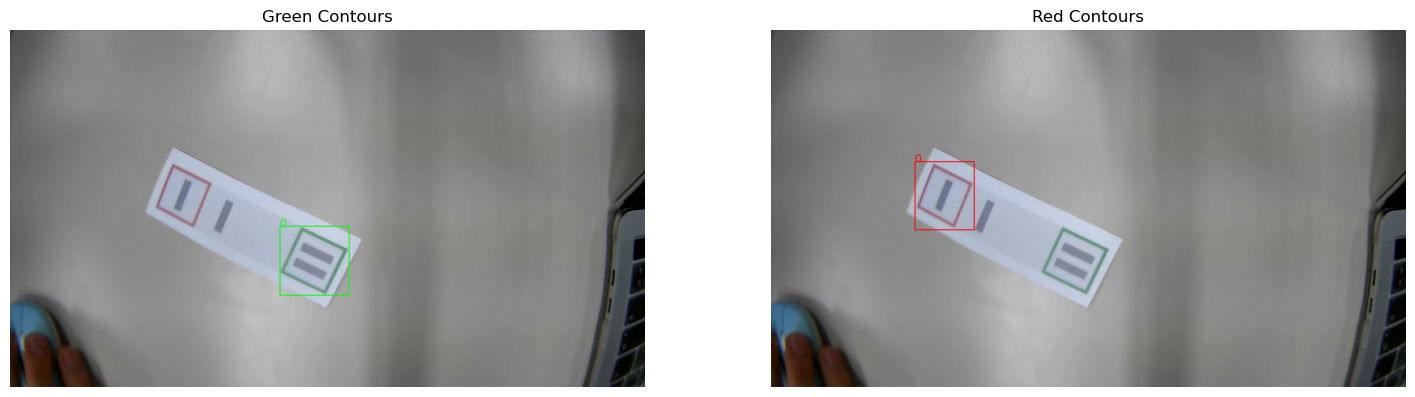

In [983]:
# Filter the contours by aspect ratio and area
filtered_green_contours = find_contours(filtered_green)
filtered_red_contours = find_contours(filtered_red)

# Number of contours
print('Number of contours green found = ', len(filtered_green_contours))
print('Number of contours red found = ', len(filtered_red_contours))

# Draw the contours on the image
contours_green_image = np.copy(image)
contours_red_image = np.copy(image)

index = 0
for contour in filtered_green_contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(contours_green_image, (x, y), (x+w, y+h), (0, 255, 0), 2)
    # Write the index of the contour in the image
    cv2.putText(contours_green_image, str(index), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    index += 1

index = 0
for contour in filtered_red_contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(contours_red_image, (x, y), (x+w, y+h), (255, 0, 0), 2)
    # Write the index of the contour in the image
    cv2.putText(contours_red_image, str(index), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    index += 1

# Display the image with the bounding boxes
plt.figure(figsize=[18, 5])
plt.subplot(1, 2, 1) ; plt.imshow(contours_green_image) ; plt.axis('off'); plt.title('Green Contours') 
plt.subplot(1, 2, 2) ; plt.imshow(contours_red_image) ; plt.axis('off') ; plt.title('Red Contours')
plt.show()

In [984]:
def extract_contour_info(contours):
    contour_info = []

    for contour in contours:
        area = round(cv2.contourArea(contour), 3)
        x, y, w, h = cv2.boundingRect(contour)
        perimeter = round(cv2.arcLength(contour, True), 3)
        # Get the real corners of the contour, could not be the same as the bounding box and could be affine
        # transformed
        rect = cv2.minAreaRect(contour)
        box = cv2.boxPoints(rect)
        box = np.int16(box)
        corners = [(corner[0], corner[1]) for corner in box]

        contour_info.append({
            'corners': corners,  # Esquinas en relación a la imagen original
            'center': (round(x + w / 2, 3), round(y + h / 2, 3)),
            'width': round(w, 3),
            'height': round(h, 3),
            'area': area,
            'aspect_ratio': round(w / h, 3) if h != 0 else None,
            'perimeter': perimeter,
            'angle': round(cv2.minAreaRect(contour)[-1], 3)
        })

    return contour_info

green_contour_info = extract_contour_info(filtered_green_contours)
red_contour_info = extract_contour_info(filtered_red_contours)

print("Green Contours Info:", green_contour_info)
print("Red Contours Info:", red_contour_info)

Green Contours Info: [{'corners': [(808, 734), (878, 588), (1027, 660), (957, 806)], 'center': (920.5, 697.5), 'width': 209, 'height': 209, 'area': 26187.5, 'aspect_ratio': 1.0, 'perimeter': 677.938, 'angle': 25.641}]
Red Contours Info: [{'corners': [(424, 552), (488, 393), (627, 450), (562, 608)], 'center': (524.5, 501.0), 'width': 179, 'height': 206, 'area': 22393.5, 'aspect_ratio': 0.869, 'perimeter': 636.683, 'angle': 22.135}]


In [985]:
def match_contours(red_contours_info, green_contours_info):
    matches = []

    for red_contour in red_contours_info:
        best_match = None
        best_angle_match = float('inf')  # Para encontrar el mejor ángulo
        best_score = float('inf')       # Para desempatar usando área y perímetro

        for green_contour in green_contours_info:
            # Calcular distancia entre centros
            center_distance = np.linalg.norm(
                np.array(red_contour['center']) - np.array(green_contour['center'])
            )

            # Descartar si la distancia excede 3.5 veces la anchura del contorno rojo
            if center_distance > 3.2 * red_contour['width']:
                continue

            # Calcular diferencia de ángulo
            angle_diff = abs(red_contour['angle'] - green_contour['angle'])

            # Descartar si la diferencia de ángulo es mayor a 10 grados
            if angle_diff > 20:
                continue

            # Calcular diferencias adicionales para desempatar
            area_diff = abs(red_contour['area'] - green_contour['area'])
            perimeter_diff = abs(red_contour['perimeter'] - green_contour['perimeter'])

            # Crear puntaje de desempate
            score = area_diff + perimeter_diff

            # Actualizar el mejor match
            if angle_diff < best_angle_match or (angle_diff == best_angle_match and score < best_score):
                best_angle_match = angle_diff
                best_score = score
                best_match = green_contour

        if best_match:
            matches.append((red_contour, best_match))

    return matches

# Emparejar los contornos
matched_contours = match_contours(red_contour_info, green_contour_info)

# Mostrar los emparejamientos
for red, green in matched_contours:
    print(f"Red contour {red['center']} matched with Green contour {green['center']}")


Red contour (524.5, 501.0) matched with Green contour (920.5, 697.5)


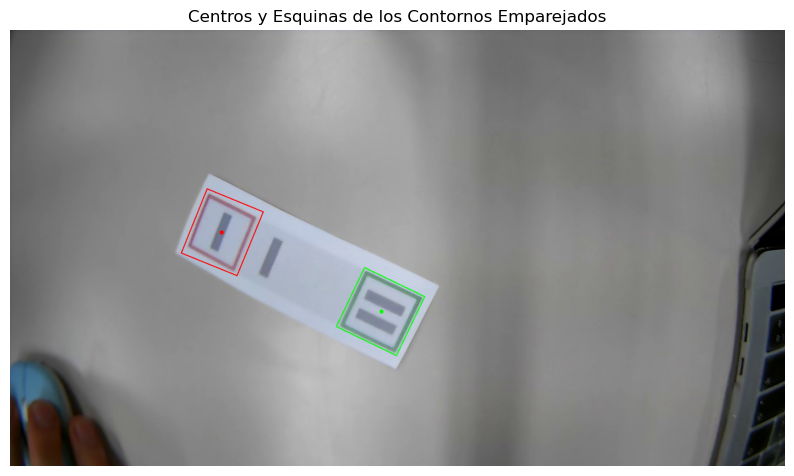

In [986]:
# Crear una copia de la imagen original para dibujar los contornos emparejados
image_with_centers_and_corners = np.copy(image)

# Dibujar los contornos emparejados
for red_contour, green_contour in matched_contours:
    # Dibujar el centro del contorno rojo
    cv2.circle(image_with_centers_and_corners, (int(red_contour['center'][0]), int(red_contour['center'][1])), 5, (255, 0, 0), -1)
    # Dibujar las esquinas del contorno rojo
    for i in range(4):
        cv2.line(image_with_centers_and_corners, tuple(red_contour['corners'][i]), tuple(red_contour['corners'][(i + 1) % 4]), (255, 0, 0), 2)

    # Dibujar el centro del contorno verde
    cv2.circle(image_with_centers_and_corners, (int(green_contour['center'][0]), int(green_contour['center'][1])), 5, (0, 255, 0), -1)
    # Dibujar las esquinas del contorno verde
    for i in range(4):
        cv2.line(image_with_centers_and_corners, tuple(green_contour['corners'][i]), tuple(green_contour['corners'][(i + 1) % 4]), (0, 255, 0), 2)

        

# Mostrar la imagen con los centros y esquinas dibujados
plt.figure(figsize=[10, 10])
plt.imshow(image_with_centers_and_corners)
plt.axis('off')
plt.title('Centros y Esquinas de los Contornos Emparejados')
plt.show()

In [987]:
def cut_bounding_box(matched_contours, image):
    extracted_images = []

    for red_contour, green_contour in matched_contours:
        # Obtener los puntos de los contornos
        red_points = np.array(red_contour['corners'])
        green_points = np.array(green_contour['corners'])

        # Combinar los puntos de ambos contornos
        all_points = np.vstack((red_points, green_points))

        # Calcular la bounding box que contenga todos los puntos
        x_min, y_min = np.min(all_points, axis=0)
        x_max, y_max = np.max(all_points, axis=0)

        # Convertir los centros a tuplas de enteros
        red_center = tuple(map(int, red_contour['center']))
        green_center = tuple(map(int, green_contour['center']))

        # # Dibujar la línea que une los centros en la imagen original
        # cv2.line(image, red_center, green_center, (255, 0, 0), 2)

        # Calcular el ángulo entre los centros
        x0, y0 = red_contour['center']
        x1, y1 = green_contour['center']
        angle = np.arctan2(y1 - y0, x1 - x0) * 180 / np.pi
        print(f"Angle between centers: {angle:.2f}°")

        # Rotar la imagen original para que la línea entre los centros sea horizontal
        M = cv2.getRotationMatrix2D(red_center, angle, 1)
        rotated_image = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))
        
        # Transformar las coordenadas de los contornos según la rotación
        ones = np.ones((red_points.shape[0], 1))
        red_points_homogeneous = np.hstack([red_points, ones])
        transformed_red_points = (M @ red_points_homogeneous.T).T

        green_points_homogeneous = np.hstack([green_points, ones])
        transformed_green_points = (M @ green_points_homogeneous.T).T

        # Combinar los puntos transformados
        transformed_all_points = np.vstack((transformed_red_points, transformed_green_points))

        # Calcular la nueva bounding box en la imagen rotada
        x_min, y_min = np.min(transformed_all_points, axis=0).astype(int)
        x_max, y_max = np.max(transformed_all_points, axis=0).astype(int)

        # Recortar la imagen rotada usando la nueva bounding box
        cropped_image = rotated_image[y_min:y_max, x_min:x_max]

        # Guardar la imagen recortada
        extracted_images.append(cropped_image)
    
    return extracted_images
   

Angle between centers: 26.39°


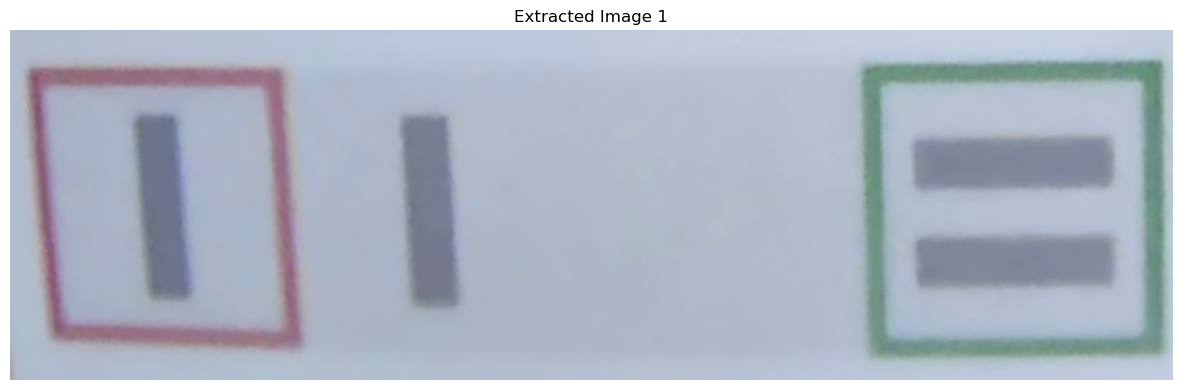

In [988]:
extracted_images = cut_bounding_box(matched_contours, image)

plt.figure(figsize=[15, 10])
for i, img in enumerate(extracted_images):
    plt.subplot(1, len(extracted_images), i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Extracted Image {i+1}')
plt.show()